In [ ]:
!pip install kaggle --quiet

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d nicolejyt/facialexpressionrecognition

Dataset URL: https://www.kaggle.com/datasets/nicolejyt/facialexpressionrecognition
License(s): unknown
  0% 0.00/96.6M [00:00<?, ?B/s]
100% 96.6M/96.6M [00:00<00:00, 1.33GB/s]


In [ ]:
!unzip facialexpressionrecognition.zip

Archive:  facialexpressionrecognition.zip
  inflating: fer2013.csv             


In [ ]:
import cudf
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical

# Assuming the CSV file exists at the specified path
df = cudf.read_csv("/content/fer2013.csv")
print(df.head())
print(df.shape)

df_pixels = df['pixels'].to_pandas()

images = []
for pixel_str in df_pixels:
    img = np.array(pixel_str.split(), dtype=np.uint8).reshape(48, 48, 1)
    images.append(img)

images = np.array(images, dtype='float32') / 255.0
labels = to_categorical(df['emotion'].values_host, num_classes=7)

print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training
(35887, 3)
Images shape: (35887, 48, 48, 1)
Labels shape: (35887, 7)


In [ ]:
from sklearn.model_selection import train_test_split
x=images
y=labels
x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=0.2,random_state=42)

In [33]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(48, 48, 3)


for layer in base_model.layers:
    layer.trainable = False


model = Sequential([

    Conv2D(3, (1,1), padding='same', input_shape=(48,48,1)),

    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')
])

# کامپایل مدل
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 48, 48, 3)      │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,880,845 (56.77 MB)

 Trainable params: 165,645 (647.05 KB)

 Non-trainable params: 14,715,200 (56.13 MB)

In [34]:
history= model.fit(x_train,y_train,epochs=50,batch_size=64,validation_data=(x_val,y_val))

Epoch 1/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 35s 62ms/step - accuracy: 0.1544 - loss: 2.4794 - val_accuracy: 0.2969 - val_loss: 1.7420
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.2433 - loss: 1.9613 - val_accuracy: 0.3182 - val_loss: 1.6998
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.2639 - loss: 1.8710 - val_accuracy: 0.3291 - val_loss: 1.6817
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - accuracy: 0.2808 - loss: 1.8037 - val_accuracy: 0.3320 - val_loss: 1.6670
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.2917 - loss: 1.7702 - val_accuracy: 0.3352 - val_loss: 1.6578
Epoch 6/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - accuracy: 0.2982 - loss: 1.7516 - val_accuracy: 0.3437 - val_loss: 1.6477
Epoch 7/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.3103 - loss: 1.7317 - val_accuracy: 0.3486 - val_loss: 1.6482
Epoch 8/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.3143 - loss: 1.7117 - 

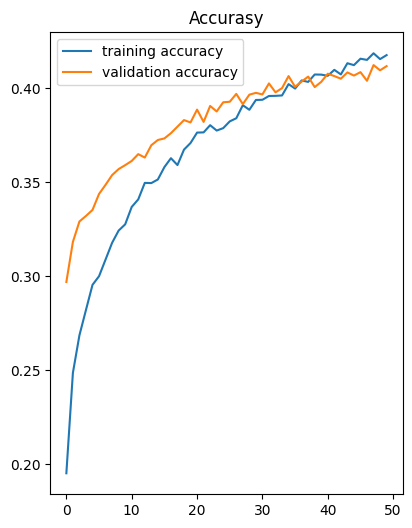

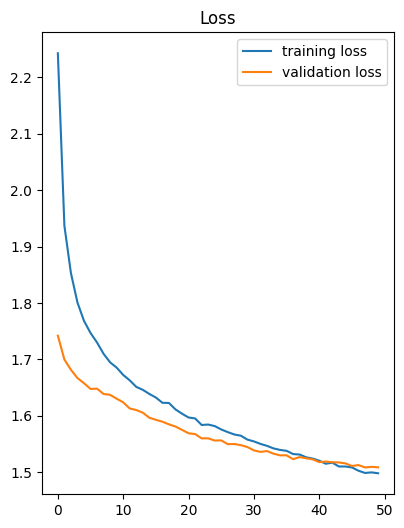

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.title('Accurasy')
plt.legend()

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.title('Loss')
plt.legend()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


TypeError: imshow() missing 1 required positional argument: 'X'

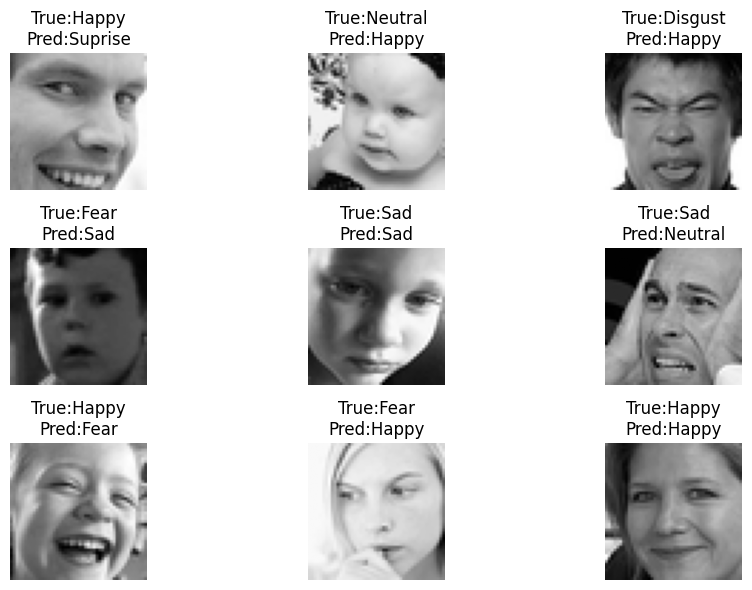

In [36]:
import random

emotion_lables=['Angry','Disgust','Fear','Happy','Sad','Suprise','Neutral']

plt.figure(figsize=(10,6))
for i in range(9):
  idx=random.randint(0,len(x_test)-1)
  img=x_test[idx]
  label=np.argmax(y_test[idx])
  pred=np.argmax(model.predict(img.reshape(1,48,48,1)))
  plt.subplot(3,3,i+1)
  plt.imshow(img.reshape(48,48),cmap='gray')
  plt.title(f'True:{emotion_lables[label]}\nPred:{emotion_lables[pred]}')
  plt.axis('off')

plt.tight_layout()
plt.imshow()
